# World Data League 2022

## Notebook Submission Template

This notebook is one of the mandatory deliverables when you submit your solution. Its structure follows the WDL evaluation criteria and it has dedicated cells where you should add information. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work. Make sure to list all the datasets used besides the ones provided.

Instructions:
1. 🧱 Create a separate copy of this template and **do not change** the predefined structure
2. 👥 Fill in the Authors section with the name of each team member
3. 💻 Develop your code - make sure to add comments and save all the output you want the jury to see. Your code **must be** runnable!
4. 📄 Fill in all the text sections
5. 🗑️ Remove this section (‘Notebook Submission Template’) and any instructions inside other sections
6. 📥 Export as HTML and make sure all the visualisations are visible.
7. ⬆️ Upload the .ipynb file to the submission platform and make sure that all the visualisations are visible and everything (text, images, ..) in all deliverables renders correctly.


## 🎯 Challenge
*First Phase*


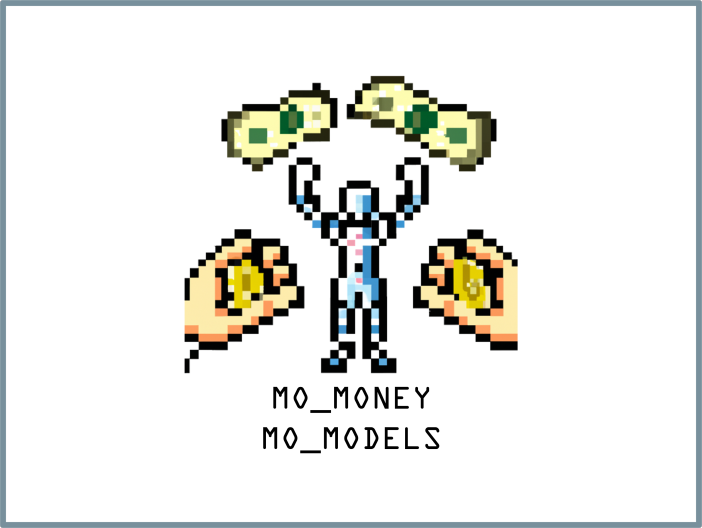
## Team: Mo Money, Mo Models
## 👥 Authors
* David Raposo
* Duarte Pereira
* Martim Chaves
* Paulo Sousa

## 💻 Development
Start coding here! 🐱‍🏍

Create the necessary subsections (e.g. EDA, different experiments, etc..) and markdown cells to include descriptions of your work where you see fit. Comment your code. 

All new subsections must start with three hash characters. More specifically, don't forget to explore the following:
1. Assess the data quality
2. Make sure you have a good EDA where you enlist all the insights
3. Explain the process for feature engineering and cleaning
4. Discuss the model / technique(s) selection
5. Don't forget to explore model interpretability and fairness or justify why it is not needed

Pro-tip 1: Don't forget to make the jury's life easier. Remove any unnecessary prints before submitting the work. Hide any long output cells (from training a model for example). For each subsection, have a quick introduction (justifying what you are about to do) and conclusion (results you got from what you did). 

Pro-tip 2: Have many similiar graphs which all tell the same story? Add them to the appendix and show only a couple of examples, with the mention that all the others are in the appendix.

Pro-tip 3: Don't forget to have a motivate all of your choices, these can be: Data-driven, constraints-driven, literature-driven or a combination of any. For example, why did you choose to test certain algorithms or why only one.

## Introduction
Have you ever found yourself in a crowded area where it's difficult to move around, or perhaps in a situation where there are too many people in one place and it becomes uncomfortable or unsafe? Our CNN-LSTM model for forecasting phone distribution could be the solution you need within the city of Lisbon! The current metro area population of Lisbon in 2023 is 3,001,000, a 0.5% increase from 2022. [1]

Although we encountered some challenges with training time and had to limit the learning rate, epochs, and batch size, we believe this model can have a significant impact on the city of Lisbon. By leveraging the data from phone towers in Lisbon, this model can detect areas with increased people flow and alert city managers, detecting and preventing overcrowding situations before they occur.

We are continually improving this model and plan to add more data sources, such as metro station/route data and climate data, to make it even more accurate and effective. Our goal is to apply this model to other cities and regions around the world, potentially even beyond city planning and management, as it has a wide range of potential applications.

As such, we performed the following tasks:
* 📱 Phone Grid Dataset
    * Exploratory Analysis
    * Cleaning
* ⚙️ Modelling
    * CNN-LSTM Architecture
    * Data Ingestion
    * Training
    * Performance Evaluation
* 🚇 Metro Station Dataset - Exploratory Analysis & Proof-of-Concept

## **TODO** 📱 Phone Grid Dataset - Exploratory Analysis
The phone grid dataset constitutes a valuable indicator for people's movement within the city of Lisbon.

## **TODO** 📱 Phone Grid Dataset - Cleaning
The phone grid dataset, collected from phone towers in the city of Lisbon, contains variables representing phones staying, exiting, and entering grids, as well as which of those are in roaming. 

We performed exploratory analysis and cleaning tasks, including dealing with missing values and outliers.

## **TODO** ⚙️ Modelling - CNN-LSTM Architecture

The pruposed CNN-LSTM architecture joins state-of-the-art deep learning models for image processing (CNN, Convolutional Neural Network) and time series forecasting (LSTM, Long Short-Term Memory).

In theory, this model is able to leverage the spatial relationships within the city grid to provide better predictions based on neighbor relations, as well as the temporal dimension for forecasting.

## **TODO** ⚙️Modelling - Data Ingestion
Reshaping data for model inputation (aqui?)

Val and test data are split from training data, and correspond to the last month, ~2 weeks each. Cross-validation can be a valuable alternative for a future iteration.

## **TODO** ⚙️Modelling - Training

## **TODO** ⚙️Modelling - Performance Evaluation

## **TODO** 🚇 Metro Station Dataset - Exploratory Analysis & Proof-of-Concept
In addition to the phone grid data, we intend to add metro station/route data and climate data, such as temperature and precipitation, in future implementations. 

We developed a proof-of-concept for the metro station dataset, which involves transforming the data to concatenate with the phone grid and have the same resolution as the grid (200 x 200 meter units).

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

## TODO 📱 Phone Grid Dataset - Exploratory Data Analysis

## **TODO** ⚙️Modelling - Performance

## **TODO** 🚇 Metro Station Dataset - Exploratory Analysis

## TODO - Conclusion

Future Work:
* Add transports and climate datasets to modelling and compare performance with benchmark
* Cross-validation
* Run on less limited time constraints and with GPU processing
* Increase the number of layers
* Encode time-of-day and day-of-week information (handle rush hours and weekend/workdays)

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

[1] city of Lisbon population in 2023 - https://www.macrotrends.net/cities/22167/lisbon/population#:~:text=The%20current%20metro%20area%20population,a%200.51%25%20increase%20from%202020. - last accessed 18/04/2023

[2] CNN-LSTM model - https://github.com/Pradnya1208/Time-series-forecasting-using-Deep-Learning  - last accessed 18/04/2023

[3] lr_scheduler - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler  - last accessed 18/04/2023


## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
